### Using Bert for word embeddings

In [7]:
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import torch

In [2]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states = True)

c:\Python310\lib\site-packages\huggingface_hub\file_download.py:129: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\WC5SZ5K\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
# will be 11 Tokens for Bert
sentence = "Sphinx of black quartz, judge my vow."

In [14]:
# Bert and encode_plus
inputs = tokenizer.encode_plus(sentence, return_tensors="pt")

with torch.no_grad():
    model.eval()
    outputs = model(**inputs)
    hidden_states = outputs[2]

print(f"Number of layers: {len(hidden_states)} (initial embeddings + 12 BERT layers)")
print(f"Number of batches: {len(hidden_states[0])}")
print(f"Number of tokens: {len(hidden_states[0][0])}")
print(f"Number of hidden units: {len(hidden_states[0][0][0])}")

Number of layers: 13 (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 11
Number of hidden units: 768


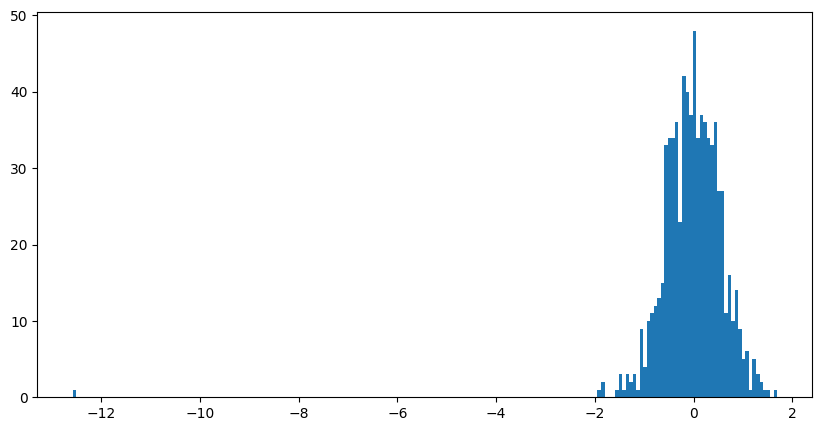

In [17]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][0][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,5))
plt.hist(vec, bins=200)
plt.show()

In [18]:
# clean up hidden states
token_embeddings = torch.stack(hidden_states, dim=0)
token_embeddings = torch.squeeze(token_embeddings, dim=1)
# switch to tokens, layers, features
token_embeddings = token_embeddings.permute(1,0,2)
token_embeddings.size()

torch.Size([11, 13, 768])

In [20]:
# create a single feature vector per token
token_vecs_sum = []

# For each token in the sentence...
for token in token_embeddings:
    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print(f"Shape is: {len(token_vecs_sum)} x {len(token_vecs_sum[0])}")

Shape is: 11 x 768


In [27]:
inputs["input_ids"]

tensor([[  101, 27311,  1997,  2304, 20971,  1010,  3648,  2026, 19076,  1012,
           102]])

In [26]:
{x: tokenizer.encode(x, add_special_tokens=False) for x in sentence.split()}

{'Sphinx': [27311],
 'of': [1997],
 'black': [2304],
 'quartz,': [20971, 1010],
 'judge': [3648],
 'my': [2026],
 'vow.': [19076, 1012]}

### Using all.MiniLM-L6-v2

In [ ]:
from sentence_transformers import SentenceTransformer, util
from sklearn.decomposition import PCA
import pandas as pd
import plotly.express as px
import torch

embedder = SentenceTransformer('all-MiniLM-L6-v2')
corpus = """So she was considering in her own mind (as well as she could,
            for the hot day made her feel very sleepy and stupid), whether
            the pleasure of making a daisy-chain would be worth the trouble
            of getting up and picking the daisies, when suddenly a White
            Rabbit with pink eyes ran close by her.""".split()

df = pd.DataFrame()

for i in range(3, len(corpus)):

    corpus_embeddings = embedder.encode(corpus[:i], convert_to_tensor=True)
    three_dim = PCA(n_components=3, random_state=0).fit_transform(corpus_embeddings)

    df = pd.DataFrame(data=[x for x in three_dim], columns=["x", "y", "z"])
    df["label"] = corpus[:i]
    df["frame"] = i
    df = pd.concat([df, df])

# normalize
df["x"] = (df["x"] - df["x"].min()) / (df["x"].max() - df["x"].min())
df["y"] = (df["y"] - df["y"].min()) / (df["y"].max() - df["y"].min())
df["z"] = (df["z"] - df["z"].min()) / (df["z"].max() - df["z"].min())

### Helper Functions

In [ ]:
from sentence_transformers import SentenceTransformer, util
from sklearn.decomposition import KernelPCA
import pandas as pd

embedder = SentenceTransformer("all-MiniLM-L6-v2")

def create_pca_colors(corpus: list, normalize: bool = True) -> pd.DataFrame:
    """Converts a list of words or sentences to color vectors
    via PCA dimensionality reduction. Uses the all-MiniLM-l6-v2
    Model for embeddings.
    
    Params:
        corpus: a list of strings, either words or sentences
        normalize: optional, will normalize the values to 0-1
    
    Returns:
        DataFrame with columns: red, green, blue, label
    
    NOTE: PCA and KernelPCA (with non linear Kernel) give
    equal results.
    NOTE: TSNE was excluded here because of the higher
    computational cost in high dimensions > 50
    """
    corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)
    three_dim = KernelPCA(n_components=3, random_state=0, kernel="poly").fit_transform(corpus_embeddings)

    df = pd.DataFrame(data=[x for x in three_dim], columns=["red", "green", "blue"])
    df["label"] = corpus

    if normalize:
        df["red"] = (df["red"] - df["red"].min()) / (df["red"].max() - df["red"].min())
        df["green"] = (df["green"] - df["green"].min()) / (df["green"].max() - df["green"].min())
        df["blue"] = (df["blue"] - df["blue"].min()) / (df["blue"].max() - df["blue"].min())
    
    return df

In [ ]:
import numpy as np

def get_interpolated_colors(num_colors: int, c1: np.ndarray, c2: np.ndarray) -> list:
    """Interpolates linearly between two colors
    and returns a list of the color gradient c1 -- num_colors -- c2
    """
    segment_len = np.linalg.norm(c2 - c1) / (num_colors+1)
    t = (c2 - c1) / np.linalg.norm(c2 - c1)
    return [c1 + t*segment_len*i for i in range(num_colors+2)]

In [ ]:
import PIL.Image
import PIL.ImageDraw
import PIL.ImageFont
import imageio.v2 as imageio


def save_as_gif(colors: pd.DataFrame, filepath: str, size: tuple = (300, 300), freq: int = 5,
                font_size: int = 25, interpolate: bool = False):
    """Creates and saves a gif from the word to color DataFrame
    
    Params:
        colors: DataFrame with red, green, blue, label
        filepath: destination for gif
        size: a tuple with (width, height)
        freq: repeat rate of frames per color, higher value -> longer per color
        font_size: size of the text
        interpolate: optional, linearly interpolates between different colors for smoother transition
    """
    images = []
    fnt = PIL.ImageFont.truetype("FreeMono.ttf", font_size)
    for i, row in colors.iterrows():
        if interpolate:
            c1 = np.array([row["red"], row["green"], row["blue"]])
            if i < colors.shape[0]-1:
                row_2 = colors.iloc[i+1, :]
                c2 = np.array([row_2["red"], row_2["green"], row_2["blue"]])
            else:
                c2 = c1.copy()
            # leave out the last element because it is the next color in the cycle
            gradient = get_interpolated_colors(freq-1, c1, c2)[:-1]
            for c in gradient:
                img = PIL.Image.new("RGB", size, tuple((c*255).astype(int)))
                ctx = PIL.ImageDraw.Draw(img)
                label = " ".join(row["label"])
                ctx.text((50, 100), label, fill=(255, 255, 255), font=fnt, stroke_width=1)
                images.append(img)
        else:
            img = PIL.Image.new("RGB", size, (int(row["red"]*255), int(row["green"]*255), int(row["blue"]*255)))
            ctx = PIL.ImageDraw.Draw(img)
            label = " ".join(row["label"])
            ctx.text((50, 100), label, fill=(255, 255, 255), font=fnt, stroke_width=1)
            for _ in range(freq):
                images.append(img)
    imageio.mimsave(filepath, images)

In [ ]:
def create_sliding_window_corpus(corpus: str, wl: int) -> list:
    """Creates a list of sentence fragments
    
    Params:
        corpus: the text as one string
        wl: the window length of the sliding window (in words)
    
    Return:
        A list of strings with word length wl
    """
    words = corpus.split()
    return [words[i:i+wl] for i in range(len(words)-wl)]

In [ ]:
import re

def remove_punctuation(s: str) -> str:
    """Removes punctuation from the string"""
    return re.sub(r"[^\w\s]", "", s)

### Testing

In [ ]:
corpus = """So she was considering in her own mind (as well as she could,
            for the hot day made her feel very sleepy and stupid), whether
            the pleasure of making a daisy-chain would be worth the trouble
            of getting up and picking the daisies, when suddenly a White
            Rabbit with pink eyes ran close by her."""

In [48]:
with open("alice.txt", "r") as file:
    corpus = file.read()

In [ ]:
create_sliding_window_corpus(corpus, 5)

In [ ]:
colors = create_pca_colors(corpus.split())
save_as_gif(colors, "test.gif", interpolate=True, size=(300, 300))
from IPython.display import Image
Image("test.gif") 

In [ ]:
# check for linearity of the color space
# using PCA or kernel PCA with a POLY KERNEL does not change
# the output too much
colors = create_pca_colors(corpus)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = colors["red"].to_numpy().reshape(-1, 1)
Y = colors["blue"].to_numpy().reshape(-1, 1)

regressor = LinearRegression().fit(X, Y)
r2_score(regressor.predict(X), Y)

In [ ]:
# NOTE: upper case and lower case makes a difference, as well as punctuation
# should we exclude punctuation?
colors = create_pca_colors("Some Some, some some. some!".split())
save_as_gif(colors, "test.gif")
from IPython.display import Image
Image("test.gif") 

### Tokenize with Huggingface

In [ ]:
from transformers import AutoTokenizer
from transformers import BertModel
import torch

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states = True)

In [ ]:
batch = [
    "But what about second breakfast?",
    "Don't think he knows about second breakfast, Pip.",
    "What about elevensies?",
]
encoded_input = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
with torch.no_grad():
    outputs = model(encoded_input["input_ids"], encoded_input["attention_mask"])
    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[-1]

print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0
print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0
print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0
print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))